# PROJECT CODE

Importing functions and modules.

In [1]:
import numpy as np
import pandas as pd
import time
import copy

import pycbc
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.noise.reproduceable import colored_noise
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter, highpass, resample_to_delta_t
from pycbc.cosmology import redshift
from pycbc.catalog import Merger
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle, UniformRadius,UniformSky
from pycbc.frame import read_frame
from pycbc.transforms import MchirpQToMass1Mass2
from pycbc.workflow.configparser_test import read_ini_file

from astropy.utils.data import download_file

from matplotlib import pyplot as plt
from matplotlib import animation

from IPython.display import display, Markdown

from tsmoothie.smoother import *

from scipy.stats import norm

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


## Defining Functions

Using code from $\textit{LISA Sensitivity and SNR Calculations (2108.01167)}$ paper and gitlab.

In [2]:
# https://gitlab.in2p3.fr/LISA/lisa_sensitivity_snr
def PSD_Noise_components(fr, sqSnoise):
    [sqSacc_level, sqSoms_level] = sqSnoise
    # sqSacc_level: Amplitude level of acceleration noise [3e-15]
    # sqSoms_level: Amplitude level of OMS noise [15e-12]
    
    
    ### Acceleration noise
    Sa_a = sqSacc_level**2 *(1.0 +(0.4e-3/fr)**2)*(1.0+(fr/8e-3)**4)
    Sa_d = Sa_a*(2.*np.pi*fr)**(-4.)
    Sa_nu = Sa_d*(2.0*np.pi*fr/c)**2

    ### Optical Metrology System
    Soms_d = sqSoms_level**2 * (1. + (2.e-3/fr)**4)
    Soms_nu = Soms_d*(2.0*np.pi*fr/c)**2
    
    return [Sa_nu, Soms_nu]

Defining function to generate waveform over distance d, mass m.

In [3]:
def waveform(d,m,dt=0.5,plot=False,shift=True):
    #Approximate frequency for a given mass.
    f = (1/(m))*200
    #Generate waveform time domain.
    hp,hc = get_td_waveform(approximant="TaylorF2",
                         mass1=m, mass2=m,
                         f_lower=f, delta_t=dt,distance=d,inclination=0,f_ref=f)
    hf = hp.to_frequencyseries()
    
    #Timeshifiting to epoch 0.
    epoch = -1*(hp.duration)+0.2
    
    if shift:
        hp = hp.cyclic_time_shift(epoch)
    
    #Plotting if relevant.
    if plot:
        print(f'Length of Time Series: {len(hp)}')
        
        plt.figure(0)
        plt.plot(hp.sample_times,hp.real())
        plt.xlabel('Time (s)')
        plt.ylabel('Strain')

        plt.figure(1)
        plt.plot(hf.sample_frequencies, hf.real())
        plt.xscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Strain')
    
    #Returning time series, frequency series and length of time series.
    return hp,hf,len(hp)

Function to reset the PSD calculation in iterations if the PSD has been modified.

In [4]:
def regenPSD():
    #Speed of Light (m/s)
    c = 299792458.0

    # Noise level in the Science Requirement Document
    sqSnoise_SciRD = [3e-15,15e-12]

    #Arm-length in meters.
    L_m = 2.5e9
    #Converting to seconds.
    L = L_m/c
    #Delta_f of PSD.
    df = 2e-7
    fMin = df
    pts = (5000000*k**k)+1
    fMax = fMin + pts*(df/k)
    #Range of frequencies to generate PSD.
    fr = np.arange(fMin,fMax,(df/k))

    #Generating noise components using function from LISA Sensitivty and SNR Calculations (2108.01167).
    Sa_nu, Soms_nu = PSD_Noise_components(fr, sqSnoise_SciRD)

    #Phi of L.
    phiL = 2*np.pi*fr*L

    #Interpolation of data from LISA Sensitivity and SNR (2108.01167) to new frequency range.
    AvFXp2 = np.interp(fr,freqs,AvFXp2_Raw)

    #Returning PSD calculated using equation from LISA Sensitivity and SNR (2108.01167) as PyCBC frequency series.
    psd = pycbc.types.frequencyseries.FrequencySeries((Soms_nu + Sa_nu*(3+np.cos(2*phiL)) ) / (phiL**2 * AvFXp2/4**2),delta_f=df)
    #Print number of points in frequency range.
    #print(f'Total Number of Frequency Points: {len(fr)}')
    return psd

## Testing and Applying

Using waveform function to create and plot a waveform of the collision of 2 Sagittarius A* mass black holes.

Length of Time Series: 524288


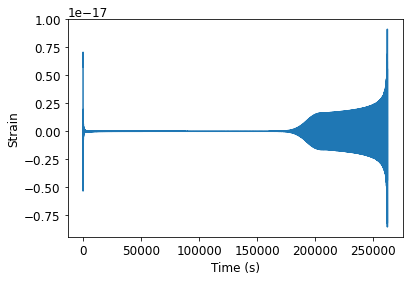

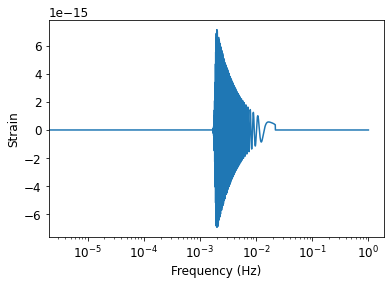

In [25]:
#Testing function with computationally demanding waveform.
hp,hf,length = waveform(200,1e5,dt=0.5,plot=True)

### Semi-Analytical PSD

Setting constants for semi-analytical PSD.

In [26]:
#Speed of Light (m/s)
c = 299792458.0

# Noise level in the Science Requirement Document
sqSnoise_SciRD = [3e-15,15e-12]

#Arm-length in meters.
L_m = 2.5e9
#Converting to seconds.
L = L_m/c

Loading generated data for semi-analytical PSD.

In [27]:
# https://gitlab.in2p3.fr/LISA/lisa_sensitivity_snr/-/raw/master/Data/AvFXp2_Raw.npy?inline=false
try: 
    freqs,AvFXp2_Raw = np.load('AvFXp2_Raw.npy')
except:
    ! curl https://gitlab.in2p3.fr/LISA/lisa_sensitivity_snr/-/raw/master/Data/AvFXp2_Raw.npy?inline=false > AvFXp2_Raw.npy
    time.sleep(5)
    freqs,AvFXp2_Raw = np.load('AvFXp2_Raw.npy')

Generating semi-analytical PSD from data and constants.

In [28]:
#Delta_f of PSD.
df = 2e-7
k=1
fMin = df
pts = (5000000*k**k)+1
fMax = fMin + pts*(df/k)
#Range of frequencies to generate PSD.
fr = np.arange(fMin,fMax,(df/k))

#Generating noise components using function from LISA Sensitivty and SNR Calculations (2108.01167).
Sa_nu, Soms_nu = PSD_Noise_components(fr, sqSnoise_SciRD)

#Phi of L.
phiL = 2*np.pi*fr*L

#Interpolation of data from LISA Sensitivity and SNR (2108.01167) to new frequency range.
AvFXp2 = np.interp(fr,freqs,AvFXp2_Raw)

#Returning PSD calculated using equation from LISA Sensitivity and SNR (2108.01167) as PyCBC frequency series.
psdp = (Soms_nu + Sa_nu*(3+np.cos(2*phiL)) ) / (phiL**2 * AvFXp2/4**2)
psd = pycbc.types.frequencyseries.FrequencySeries(psdp,delta_f=df)
#Print number of points in frequency range.
print(f'Total Number of Frequency Points: {len(fr)}')

Total Number of Frequency Points: 5000001


Plotting semi-analytical PSD.

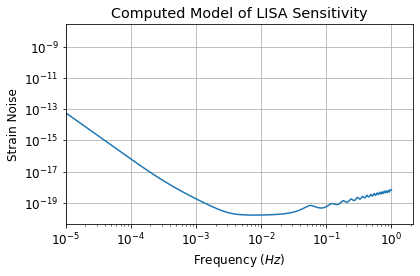

In [29]:
plt.figure()
plt.title("Computed Model of LISA Sensitivity")
plt.loglog(psd.sample_frequencies,np.sqrt(psd))
plt.xlabel('Frequency ($Hz$)')
plt.ylabel('Strain Noise')
plt.grid()
plt.xlim(1e-5)
plt.tight_layout()
plt.savefig('psds.png',facecolor='white',dpi=300)

### Detector Noise from PSD

Generating redshifted waveform and plotting to compare with non-redshifted waveform.

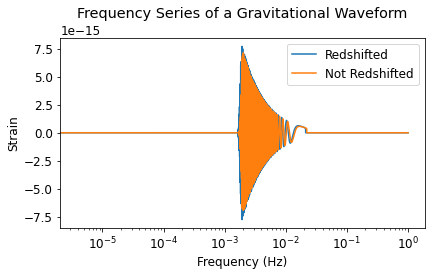

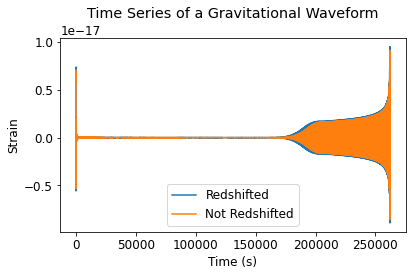

In [30]:
#Setting Distance and Mass
d=200
m=1e5
#Calculating Redshift from Distance
z=redshift(d)
#Calculating Observed Mass using Redshift
mobs = m*(z+1)

#Generating Waveform
zhp,zhf,zlength = waveform(d,mobs,dt=0.5)

#Plotting Frequency Series
plt.figure()
plt.plot(zhf.sample_frequencies,zhf.real(),label="Redshifted")
plt.plot(hf.sample_frequencies,hf.real(),label="Not Redshifted")
plt.xscale('log')
plt.legend()
plt.ylabel("Strain")
plt.xlabel("Frequency (Hz)")
plt.title("Frequency Series of a Gravitational Waveform",pad=20)
plt.tight_layout()
plt.savefig('wffs.png',facecolor='white',dpi=200)
plt.show()

#Plotting Time Series
plt.figure()
plt.plot(zhp.sample_times,zhp.real(),label="Redshifted")
plt.plot(hp.sample_times,hp.real(),label="Not Redshifted")
plt.legend()
plt.ylabel("Strain")
plt.xlabel("Time (s)")
plt.title("Time Series of a Gravitational Waveform",pad=20)
plt.tight_layout()
plt.savefig('wfts.png',facecolor='white',dpi=200)
plt.show()

Generation of detector noise using PyCBC built in function.

In [31]:
#Checking that the segment length will not return an error (Only required with noise_from_psd).
print(f'Delta_t of the PSD: {psd.delta_t}')
N = int((1/psd.delta_t)/psd.delta_f)
print(f'Length of SimNoise Segement: {(1/psd.delta_t)/psd.delta_f}')

if (N/2)+1 != len(psd):
    print('Non-integer segment length')
else:
    #Generating detector noise.
    noise = pycbc.noise.gaussian.noise_from_psd(length=len(zhp),psd=psd,delta_t=zhp.delta_t)
#noise = colored_noise(start_time=0,end_time=zhp.duration,sample_rate=2.0,psd=psd,low_frequency_cutoff=1e-5)

Delta_t of the PSD: 0.5
Length of SimNoise Segement: 10000000.0


Plotting noise generated from the PSD to demonstrate detector noise sample.

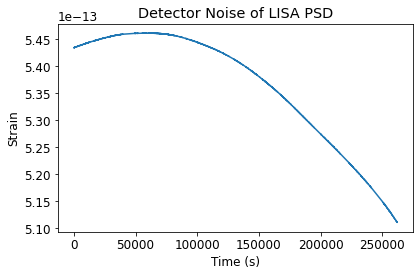

In [32]:
plt.plot(noise.sample_times,noise)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Detector Noise of LISA PSD")
plt.grid
plt.tight_layout()
plt.savefig('noise.png',facecolor='white',dpi=300)

Adding signal into noise.

In [33]:
#Adding signal hp to noise.
sig = noise + zhp
#Printing total duration of data.
print(f'Duration of Data: {sig.duration}')

Duration of Data: 262144.0


Plotting PSD of signal and noise overlayed.

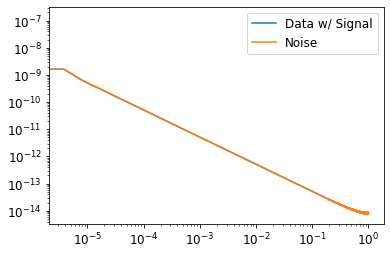

In [34]:
plt.figure()
#Data PSD
sigf = sig.to_frequencyseries()
plt.loglog(sigf.sample_frequencies, abs(sigf),label='Data w/ Signal')
#Noise PSD
noisef = noise.to_frequencyseries()
plt.loglog(noisef.sample_frequencies, abs(noisef),label='Noise')
plt.legend()

Plotting timeseries of signal and noise.

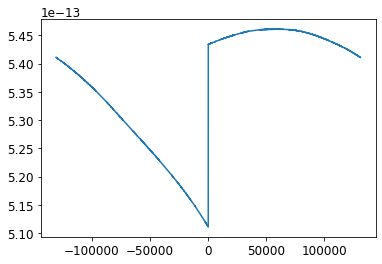

In [35]:
#Shift data to center.
sig2 = sig.cyclic_time_shift(sig.duration/2)
#Plot Signal
plt.plot(sig2.sample_times,sig2)

### SNR and Evaluation

Matched filtering signal with noisy signal and PSD to generate an SNR plot of the noisy data.

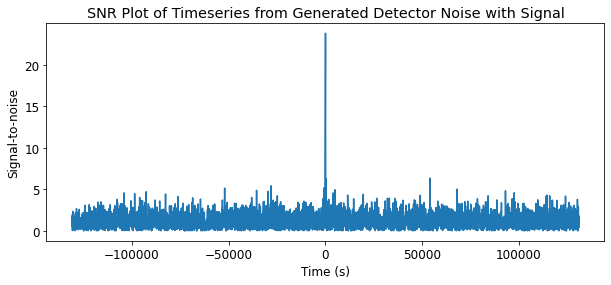

We found a signal at 17.5s with SNR 23.800073227266296


In [17]:
#Calculating SNR.
psd2 = interpolate(psd, zhp.delta_f)
snr = matched_filter(zhp, sig2,psd=psd2,low_frequency_cutoff=zhp.delta_f,high_frequency_cutoff=9e-1)

#Plotting SNR.
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.title('SNR Plot of Timeseries from Generated Detector Noise with Signal')
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

#Finding peak SNR.
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

#Printing peak SNR.
print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

Plotting and saving to file separately to prevent kernel crashes.

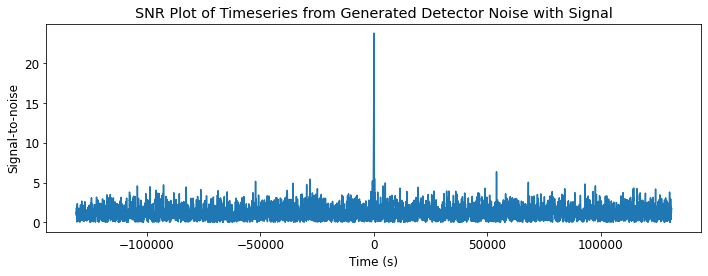

In [19]:
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.title('SNR Plot of Timeseries from Generated Detector Noise with Signal')
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.savefig('snr.png',facecolor='white',dpi=300)
plt.show()

## Mass Against Distance for SNR=15

Generating data for mass against distance plot.

In [ ]:
#Array of Masses for Iteration
cmasses = np.logspace(np.log10(5e2),np.log10(5e6),num=14)
#List to store distances
snr15_dist = []
print(f'Masses: {cmasses}')
#looping through chirp masses
for cm in cmasses[13:]:
    #arbitrary initial snr
    SNR=200
    #initial values
    d=31500
    m = (2**(1/5))*cm
    while int(abs(SNR))!=15.0:
        #calculate redshift and redshift mass value
        z=redshift(d)
        mobs = m*(z+1)
        
        #generate waveform
        zhp,zhf,zlength = waveform(d=d,m=mobs,dt=0.5)
        
        #Getting PSD and interpolate to df
        psd2 = regenPSD()
        psd2 = interpolate(psd2, zhp.delta_f)
        #sig = colored_noise(start_time=0,end_time=zhp.duration,sample_rate=2.0,psd=psd2,low_frequency_cutoff=psd2.delta_f)
        #hp = hp.cyclic_time_shift(hp.duration/2)

        #Calculate SNR
        snr = matched_filter(zhp, zhp,psd=psd2)
        
        #Find peak snr
        peak = abs(snr).numpy().argmax()
        #Get snr value
        snrp = snr[peak]
        #time of snr value
        time = snr.sample_times[peak]
        
        #check that snr is detectable by LISA
        print(f"""For chirp mass {cm}$M\odot$ at distance {d}$MPc$ the SNR is {abs(snrp)} at time {time}$s$.""")
        if int(abs(snrp)) == 15.0:
            #Let user know value has been found
            display(Markdown(rf"""For chirp mass {cm}$M\odot$ at distance {d}$MPc$ the SNR is {abs(snrp)} at time {time}$s$."""))
            snr15_dist.append(d)
        #set SNR check value
        SNR = snrp.real
        #scale factor
        sf = (SNR/15)
        #modify distance to converge on SNR 15
        d = d*sf

In [11]:
snr15_dist = [10, 60.37691104709046, 454.68404328157175, 708762.3388746998, 974903.3692742366, 772585.1826685464, 592627.2828485137, 430322.0308961559, 299479.475628806, 201786.99912053053,132974.475623053,85152.3692745398,51898.61943,31124.64816502]

Writing to file so data can be accessed again without needing to generate data.

In [12]:
#Prepare to write to file
dict = {'Chirp Mass': cmasses, 'Luminosity Distance': snr15_dist} 
df = pd.DataFrame(dict)
  
# saving the dataframe
df.to_csv('filedm.csv')

Reading generated data file.

In [13]:
df = pd.read_csv('filedm.csv')
print(df)

    Unnamed: 0    Chirp Mass  Luminosity Distance
0            0  5.000000e+02            10.000000
1            1  1.015459e+03            60.376911
2            2  2.062313e+03           454.684043
3            3  4.188388e+03        708762.338875
4            4  8.506271e+03        974903.369274
5            5  1.727554e+04        772585.182669
6            6  3.508519e+04        592627.282849
7            7  7.125513e+04        430322.030896
8            8  1.447133e+05        299479.475629
9            9  2.939008e+05        201786.999121
10          10  5.968883e+05        132974.475623
11          11  1.212231e+06         85152.369275
12          12  2.461941e+06         51898.619430
13          13  5.000000e+06         31124.648165


Plotting mass against distance plot.

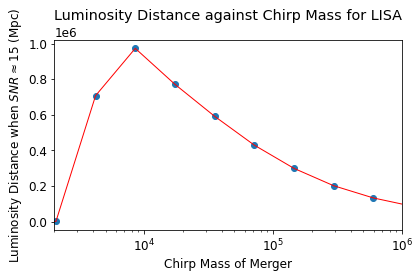

In [20]:
x=np.array(df['Chirp Mass'])
y=np.array(df['Luminosity Distance'])

smoother = BinnerSmoother(n_knots=14)
smoother.smooth(y)

low, up = smoother.get_intervals('sigma_interval', n_sigma=1)

plt.figure()
plt.plot(x,smoother.smooth_data[0], linewidth=1, color='red')
plt.scatter(x,y)
plt.xscale('log')
plt.xlabel("Chirp Mass of Merger")
plt.ylabel(r"Luminosity Distance when $SNR\approx 15$ (Mpc)")
plt.title("Luminosity Distance against Chirp Mass for LISA",pad=20)
plt.xlim(2e3,1e6)
plt.tight_layout()
plt.savefig('out.png', facecolor='white',bbox_inches="tight")
plt.show()

## Bayesian Inference

Inference without LISA changes.

In [36]:
#Placeholder Detector Name (Using LIGO H1)
ifos = ['H1']

#Defining Datasets
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    #Processing Data
    ts = sig
    ts = highpass(ts, 1e-4)
    ts = ts.cyclic_time_shift(ts.duration/2)
    ts = resample_to_delta_t(ts, 0.5)
    data[ifo] = ts.to_frequencyseries()
    
    #Processing PSD
    psd2 = regenPSD()
    psd2 = interpolate(psd2, ts.delta_f)
    psds[ifo] = psd2
    
#Approximating Frequency
f = (1/(1e5))*200
#Setting Static Parameters and Values
static = {'f_lower':f,
          'f_ref':f,
          'approximant':"TaylorF2",
          'polarization':0
         }
#Setting Variable Parameters and Values
variable = ('mass1',
            'mass2',
            'distance',
            'ra',
            'dec',
            'inclination',
            'tc'
           )
#Creating Prior Distributions
prior = JointDistribution(variable,
                Uniform(
                    mass1=(0.5e5, 5e5),
                    mass2=(0.5e5, 5e5),
                    tc=(-5000,5000)),
                UniformRadius(
                    distance=(100, 600),
                ),
                SinAngle(inclination=(0,np.pi)),
                UniformSky()
        )
#Creating Model with Data, PSDs, Statics, Variables and Priors
model = models.marginalized_gaussian_noise.MarginalizedPhaseGaussianNoise(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':1e-5},
                              high_frequency_cutoff = {'H1':0.5},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              )

Processing H1 data


Loading sampler from config file.

In [39]:
#Reading File
fl = read_ini_file("dynesty-gw150914_like.ini")
#Setting up Sampler
smpl = sampler.dynesty.DynestySampler.from_config(fl, model,output_file="lisamod")

Running sampler to estimate parameters.

In [22]:
smpl.run()

85396it [45:22, 31.36it/s, +1250 | bound: 589 | nc: 1 | ncall: 2270762 | eff(%):  3.816 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  0.000 >  0.001]


Finalising sampler and preparing file to write data.

In [23]:
smpl.finalize()
#Preparing File
file = pycbc.inference.io.dynesty.DynestyFile('output2.hdf',mode='w')
file.close()

Writing data to file.

In [24]:
smpl.write_results('output2.hdf')

Plotting estimated parameters.

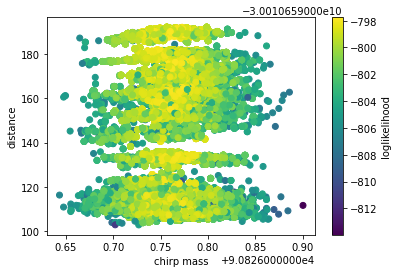

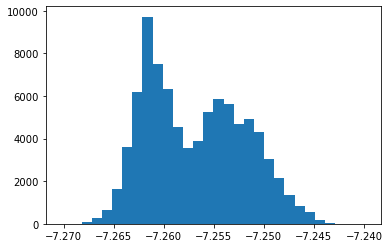

In [35]:
#Reading File
sample = pycbc.inference.io.dynesty.DynestyFile('output2.hdf',mode='r')
#Importing Samples
s = sample.read_raw_samples(['mass1','mass2','distance','ra','dec','inclination','tc'])
#Calculating Chirp Mass
cm = np.power((s['mass1']*s['mass2']),(3/5))/np.power((s['mass1']+s['mass2']),(1/5))

#Plotting Chosen Results
plt.scatter(cm,
              s['distance'],
              c=s['loglikelihood'])
plt.xlabel('chirp mass')
plt.ylabel('distance')
cB = plt.colorbar()
cB.set_label('loglikelihood')
plt.show()

#Plotting Chosen Histogram
_ = plt.hist(s['tc'], bins=30)

## LISA Changes

Importing waveform function from development branch of pycbc (https://github.com/spxiwh/pycbc/tree/lisa_changes) and function to write waveform to files.

In [51]:
from pycbc.waveform.bbhx_waveform_plugin import BBHXWaveformFDInterface as LISAWaveformFD
from pycbc.frame import write_frame

Reading PSDs from txt files for streams A, E and T.

In [52]:
psdA = pd.read_csv("A_psd.txt",sep=" ",header=None)
psdE = pd.read_csv("E_psd.txt",sep=" ",header=None)
psdT = pd.read_csv("T_psd.txt",sep=" ",header=None)

Plotting PSDs.

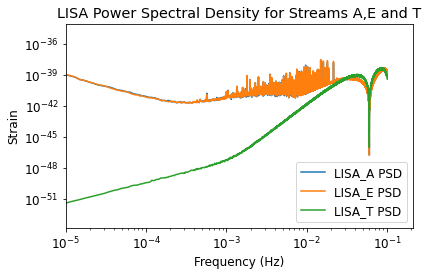

In [53]:
plt.figure()
plt.loglog(psdA[0],psdA[1],label="LISA_A PSD")

plt.loglog(psdE[0],psdE[1],label="LISA_E PSD")

plt.loglog(psdT[0],psdT[1],label="LISA_T PSD")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.title('LISA Power Spectral Density for Streams A,E and T')
plt.legend()
plt.xlim(1e-5)
plt.tight_layout()
plt.savefig('psds.png',facecolor='white',dpi=300)

Defining parameters for waveform generation.

In [54]:
#Setting Parameter Values
m = 5e4
s1 = -0.53
s2 = 0.18
d = 9000
cp = 1.98
inc = 1.03
lo = 0.33
la = -0.75
p = -1.43
tc = 1.5e7

#Calulating Redshift
z=redshift(d)
#Redshifted Mass
zm = m*(z+1)
print(zm)

#Getting Nyquist Frequency and Delta f
nf = psdA[0][len(psdA)-1]
df = psdA[0][1]

print(f'Nyquist = {nf}')
print(f'Delta f = {df}')

112816.47789832987
Nyquist = 0.1
Delta f = 3.1709791983764586e-08


Generating waveform using development branch function.

In [7]:
ha,he,ht = LISAWaveformFD(mass1=zm,mass2=zm,spin1z=s1,spin2z=s2,distance=d,coa_phase=cp,inclination=inc,eclipticlongitude=lo,eclipticlatitude=la,polarization=p,tc=tc,delta_f=df,nyquist_freq=nf)

Plotting frequency series of generated waveform for streams A,E and T.

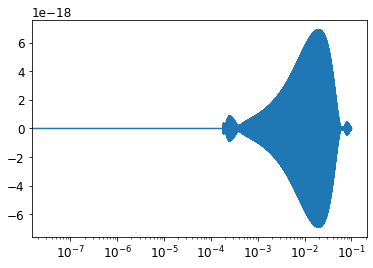

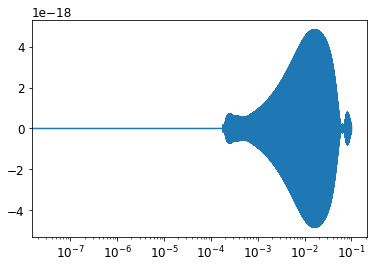

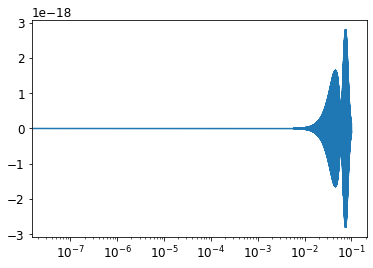

In [8]:
# A
plt.figure(1)
plt.plot(ha.sample_frequencies,ha.real())
plt.xscale('log')
plt.title("")
plt.show()

# E
plt.figure(2)
plt.plot(he.sample_frequencies,he.real())
plt.xscale('log')
plt.show()

# T
plt.figure(3)
plt.plot(ht.sample_frequencies,ht.real())
plt.xscale('log')
plt.show()

Setting delta t value.

In [9]:
dt = ha.delta_t

5.0

Coverting PSDs to pycbc FrequencySeries data type.

In [10]:
pA = pycbc.types.frequencyseries.FrequencySeries(np.array(psdA[1]),delta_f=df)
pE = pycbc.types.frequencyseries.FrequencySeries(np.array(psdE[1]),delta_f=df)
pT = pycbc.types.frequencyseries.FrequencySeries(np.array(psdT[1]),delta_f=df)

3153523
3153601


Plotting PSDs again to confirm that it is the same as the data from txt files.

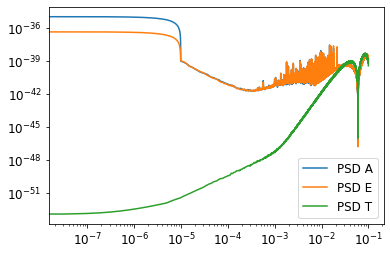

In [11]:
plt.loglog(pA.sample_frequencies,pA.real(),label="PSD A")

plt.loglog(pE.sample_frequencies,pE.real(),label="PSD E")

plt.loglog(pT.sample_frequencies,pT.real(),label="PSD T")

plt.legend()

Converting waveform to timeseries for inference.

In [12]:
tsA = ha.to_timeseries()
tsE = he.to_timeseries()
tsT = ht.to_timeseries()

31536000.0

Plotting waveform timeseries for streams A,E and T.

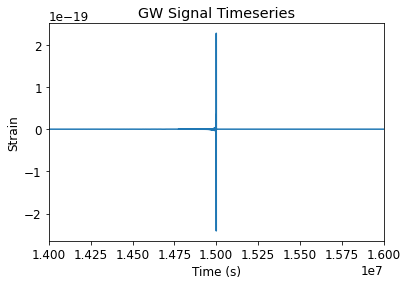

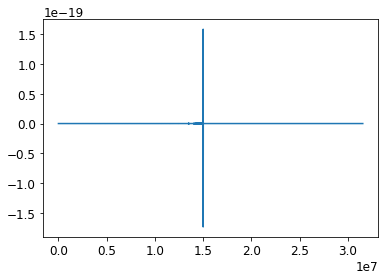

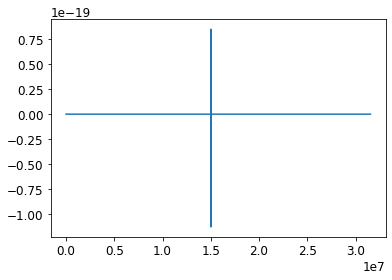

In [13]:
# A
plt.figure(4)
plt.plot(tsA.sample_times,tsA.real())
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('GW Signal Timeseries')
plt.show()

# E
plt.figure(5)
plt.plot(tsE.sample_times,tsE.real())
plt.show()

# T
plt.figure(6)
plt.plot(tsT.sample_times,tsT.real())
plt.show()

Generating noise from PSD timeseries.

In [14]:
#Getting Start Time and End Time of the Timeseries
times = [tsA,tsE,tsT]
sts = {ts.start_time for ts in times}
ets = {ts.end_time for ts in times}
st = sts.pop()
et = ets.pop()

noiseA = colored_noise(start_time=st,end_time=et,sample_rate=1/dt,psd=pA,low_frequency_cutoff=df)
noiseE = colored_noise(start_time=st,end_time=et,sample_rate=1/dt,psd=pE,low_frequency_cutoff=df)
noiseT = colored_noise(start_time=st,end_time=et,sample_rate=1/dt,psd=pT,low_frequency_cutoff=df)

Adding noise to waveform timeseries.

In [15]:
sigA = (noiseA+tsA)
sigE = (noiseE+tsE)
sigT = (noiseT+tsT)

31536000.0

Plotting timeseries of noisy waveform.

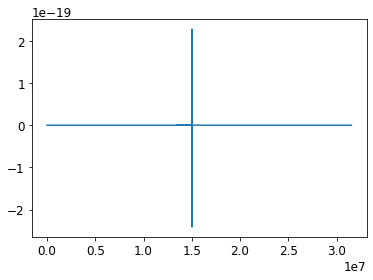

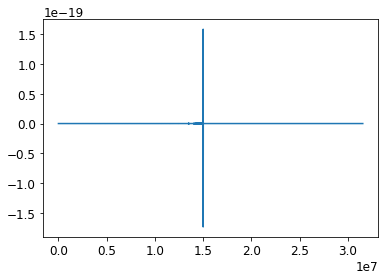

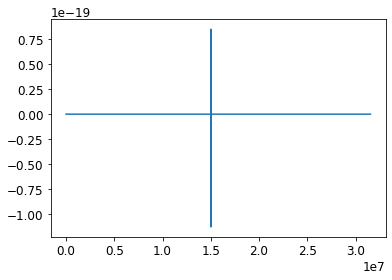

In [16]:
# A
plt.figure(4)
plt.plot(sigA.sample_times,sigA.real())
plt.show()

# E
plt.figure(5)
plt.plot(sigE.sample_times,sigE.real())
plt.show()

# T
plt.figure(6)
plt.plot(sigT.sample_times,sigT.real())
plt.show()

Writing noisy signals to frame files.

In [17]:
write_frame("tsA.gwf","LISA_A:LA",sigA)
write_frame("tsE.gwf","LISA_E:LE",sigE)
write_frame("tsT.gwf","LISA_T:LT",sigT)

Running inference using command line and config files.

In [45]:
!chmod +x run.sh
!./run.sh

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.
2022-05-23 12:04:36,743 Using seed 18934
2022-05-23 12:04:36,743 Running with CPU support: 1 threads
2022-05-23 12:04:36,743 Reading configuration file
2022-05-23 12:04:36,744 Setting up model
2022-05-23 12:04:36,745 Setting up priors for each parameter
2022-05-23 12:04:36,746 No sampling_params section read from config file
2022-05-23 12:04:36,747 Determining analysis times to use
2022-05-23 12:04:36,748 Reading Frames
2022-05-23 12:04:39,605 Resampling data
2022-05-23 12:04:39,609 Converting to float64
2022-05-23 12:04:39,611 Remove Padding
2022-05-23 12:04:39,612 Reading Frames
2022-05-23 12:04:42,469 Resampling data
2022-05-23 12:04:42,471 Converting to float64
2022-05-23 12:04:42,473 Remove Padding
2022-05-23 12:04:42,474 Reading Frames
2022-05-23 12:04:45,216 Resampling data
2022-05-23 12:04:45,218 Converting to float64
2022-05-23 12:04:45,221 Remove Padding
2022-05-

Loading inference output file and making simple plots.

/tmp/ipykernel_432/4178428208.py:10: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cB = fig.colorbar(splot,ax=None)


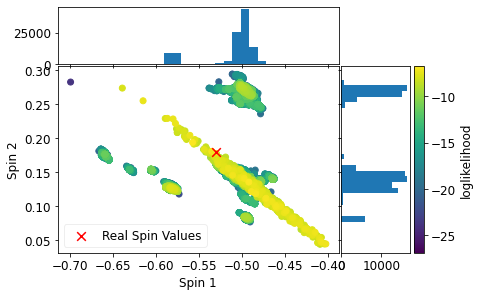

In [197]:
#Function to plot scatter histograms
def scatter_hist(x, y, ax, ax_histx, ax_histy,c):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    splot = ax.scatter(x, y,c=c,cmap='viridis')
    #colorbar
    cB = fig.colorbar(splot,ax=None)
    cB.set_label('loglikelihood')
    
    ax.set_xlabel("Spin 1")
    ax.set_ylabel("Spin 2")
    
    #plotting histograms
    ax_histx.hist(x, bins=30)
    ax_histy.hist(y, bins=30, orientation='horizontal')

#Loading File
sample = pycbc.inference.io.dynesty.DynestyFile('inferenceff.hdf',mode='r')
#['mass1','mass2','spin1z','spin2z','distance','eclipticlongitude','eclipticlatitude','inclination','polarization','coa_phase','tc']
#Importing Samples
s = sample.read_raw_samples(['mass1','mass2','spin1z','spin2z','distance','eclipticlongitude','eclipticlatitude','inclination','polarization','coa_phase','tc'])

#Calculating Chirp Mass
cm = np.power((s['mass1']*s['mass2']),(3/5))/np.power((s['mass1']+s['mass2']),(1/5))

#size of the plots
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

#defining plot shapes
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

#sorting data by loglikelihood
sort= s['loglikelihood'].argsort()
z = (s['loglikelihood'])[sort]
x = (s['spin1z'])[sort]
y = (s['spin2z'])[sort]

#creating figure
fig = plt.figure()
#creating axes for scatter histogram
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

#Plotting Chosen Parameters
scatter_hist(x, y, ax, ax_histx, ax_histy,c=z)
#real values
ax.scatter(s1,
              s2,
              c='Red',
           marker='x',
           label = "Real Spin Values",
          s=75)
ax.legend(fancybox=True, framealpha=0.33)
plt.savefig('spins.png',facecolor='white',dpi=300,bbox_inches="tight")
plt.show()

Using plot posteriors function from PyCBC to plot parameters defined in config.

In [67]:
!chmod +x plot.sh
!./plot.sh

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.
/home/firrann/miniconda3/envs/project_env/lib/python3.9/site-packages/PyCBC-2.0.1-py3.9-linux-x86_64.egg/pycbc/results/scatter_histograms.py:461: UserWarning: Attempting to set identical left == right == 113.445643435903 results in singular transformations; automatically expanding.
  ax.set_xlim(xmin, xmax)
/home/firrann/miniconda3/envs/project_env/lib/python3.9/site-packages/PyCBC-2.0.1-py3.9-linux-x86_64.egg/pycbc/results/scatter_histograms.py:793: UserWarning: Attempting to set identical left == right == 113.445643435903 results in singular transformations; automatically expanding.
  ax.set_xlim(mins[px], maxs[px])
